In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

plt.rcParams['figure.figsize'] = [6, 4]
# plt.rcParams['font.size'] = 16  # controls default text size
# plt.rcParams['legend.fontsize'] = 16

import scipy

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Arial'
# plt.rcParams['lines.marker']  #None
plt.rcParams['lines.markersize'] = 2 #6.0
plt.rcParams['lines.linewidth'] = 1   # 1.5
plt.rcParams['figure.constrained_layout.use'] = True

In [2]:
def load_data(directory, re_filter=".*"):
    """
    Returns the data from a txt file.
    The script uses the samples as the unit of time making the channel voltage array a sufficient measurement of time.
    Match the delimiter and the lines of header to your keyfile.
    """
    data_spectrum = []
    
    for file in os.listdir(directory):
        if re.match(re_filter, file):
            filename = os.fsdecode(file)
            with open(os.path.join(directory, filename), 'r') as f:
                opened = np.genfromtxt(f, delimiter=',', skip_header=5)
                data_spectrum.append(opened[:, 1])

    return data_spectrum


def plot_fft(signal, diff=None, ax=None,
            label="", color="#01665eff", save_filename=None, x_axis_values=None, ylabel=None):
    if not save_filename:
        save_filename = label.replace(' ', '_') + '.pdf'
    
    # input has units V^2/Hz. Divide by impedence (50 Ohms) and multiply by 1000 (convert to milliwatts)
    # then plot on log scale.
    spectrum = 10*np.log10(
        signal[1:1_000_001] / 50. * 1000.
    )


    if ax is None:
        fig, ax = plt.subplots()
    
    if not x_axis_values:
        x_axis_values = np.linspace(0, 5, len(spectrum))
    ax.plot(x_axis_values, spectrum, label=label, color=color, linewidth=0.5)

    if diff:
        diff = np.log10(diff[:1_000_001])
        ax.plot(x_axis_values, diff, 'r', label="Difference")
    ax.legend(loc="upper right")
    ax.set_xlabel('Frequency (GHz)')
    
    if ylabel:
        ax.set_ylabel(ylabel)
    else:
        ax.set_ylabel('PSD (dBm / Hz)')

    ax.set_ylim([-205., -90.])
    print(np.max(spectrum[2:]+5.), x_axis_values[np.argmax(spectrum[2:])])
    ax.set_xlim([0, 5])

    ax.xaxis.set_major_locator(MultipleLocator(1))
    #ax.yaxis.set_major_locator(MultipleLocator(20))

    ax.xaxis.set_minor_locator(AutoMinorLocator(10))
    #ax.yaxis.set_minor_locator(AutoMinorLocator(2))

    axesthickness = 1

    ax.grid(which='major', color='#CCCCCC')
    ax.grid(which='minor', color='#EEEEEE')

    ax.xaxis.set_tick_params(which='major', size=3, width=axesthickness, direction='in', top='on')
    ax.xaxis.set_tick_params(which='minor', size=2, width=axesthickness, direction='in', top='on')
    ax.yaxis.set_tick_params(which='major', size=3, width=axesthickness, direction='in', right='on')
    ax.yaxis.set_tick_params(which='minor', size=2, width=axesthickness, direction='in', right='on')

    # change all spines
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(axesthickness)

    # increase tick width
    ax.tick_params(width=axesthickness)

In [3]:
path_bkg = os.path.join("..", "DownloadedData", "BackgroundTuesday", "Background")
data_background = load_data(path_bkg)

path_signal = os.path.join("..", "DownloadedData", "Rev130meas2.5cm", "FPGA2.5cm")
data_signal = load_data(path_signal, 'train_[0-9]*_data.txt')

In [4]:
print(len(data_background), len(data_signal))

30 30


In [5]:
fft_signal = []
fft_background = []

nperseg = 100_000

for elem in data_signal:
    freq_axis, psd = scipy.signal.welch(elem,
                   fs=10e9,
                   nperseg=nperseg,
                   noverlap=0,  # zero for Barlett's method.
                   return_onesided=True,
                   scaling='density',
                   axis=-1,
                   average='mean',
                  )
    fft_signal.append(psd)

for elem in data_background:
    freq_axis, psd = scipy.signal.welch(elem,
                   fs=10e9,
                   nperseg=nperseg,
                   noverlap=0,  # zero for Barlett's method.
                   return_onesided=True,
                   scaling='density',
                   axis=-1,
                   average='mean',
                  )
    fft_background.append(psd)

print(np.shape(fft_background))

mean_signal = np.mean(np.array(fft_signal), axis=0)
mean_background = np.mean(np.array(fft_background), axis=0)
diff = mean_signal - mean_background

(30, 50001)


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


-95.25602454095966 0.29970599411988236
-115.11316614347638 0.8510170203404067


/tmp/ipykernel_307891/890385274.py:13: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


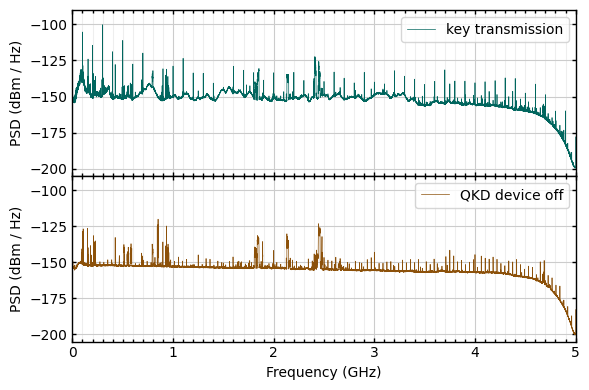

In [6]:
fig, ax = plt.subplots(2)

font = {'family' : 'Arial',
    'weight' : 'normal',
    # 'size'   : 17,
       }
plt.rc('font', **font)

plot_fft(mean_signal, label="key transmission", ax=ax[0])

plot_fft(mean_background, label="QKD device off", color="#8c510aff", ax=ax[1])
ax[0].set_xticklabels([])
plt.tight_layout()
plt.subplots_adjust(wspace=None, hspace=0)

plt.savefig("spectra.pdf", bbox_inches="tight", dpi=400)

# Same plot with subtraction

/tmp/ipykernel_307891/2449464349.py:26: RuntimeWarning: invalid value encountered in log10
  spectrum = 10*np.log10(
/tmp/ipykernel_307891/3206249882.py:12: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


nan 0.0004000080001600032
-115.11316614347638 0.8510170203404067


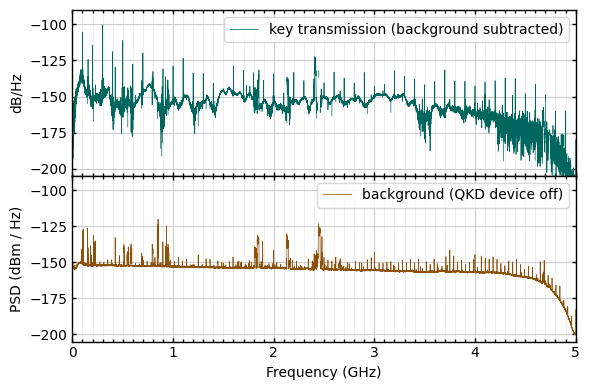

In [7]:
fig, ax = plt.subplots(2)

font = {'family' : 'Arial',
    'weight' : 'normal',
    'size'   : 10}
plt.rc('font', **font)

plot_fft(mean_signal-mean_background, label="key transmission (background subtracted)", ylabel='dB/Hz', ax=ax[0])

plot_fft(mean_background, label="background (QKD device off)", color="#8c510aff", ax=ax[1])
ax[0].set_xticklabels([])
plt.tight_layout()
plt.subplots_adjust(wspace=None, hspace=0)

plt.savefig("spectra_background_subtracted.pdf", bbox_inches="tight", dpi=400)

# Both Together

-95.25602454095966 0.29970599411988236
-115.11316614347638 0.8510170203404067


/tmp/ipykernel_307891/3320251105.py:11: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


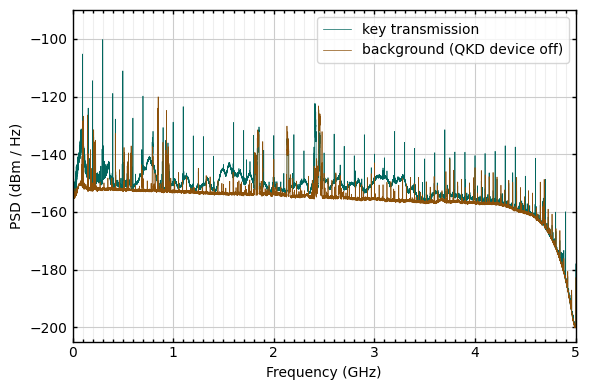

In [8]:
fig, ax = plt.subplots(1)

font = {'family' : 'Arial',
    'weight' : 'normal',
    'size'   : 10}
plt.rc('font', **font)

plot_fft(mean_signal, label="key transmission", ax=ax)

plot_fft(mean_background, label="background (QKD device off)", color="#8c510aff", ax=ax)
plt.tight_layout()
plt.savefig("spectra_background_together.pdf", bbox_inches="tight", dpi=400)

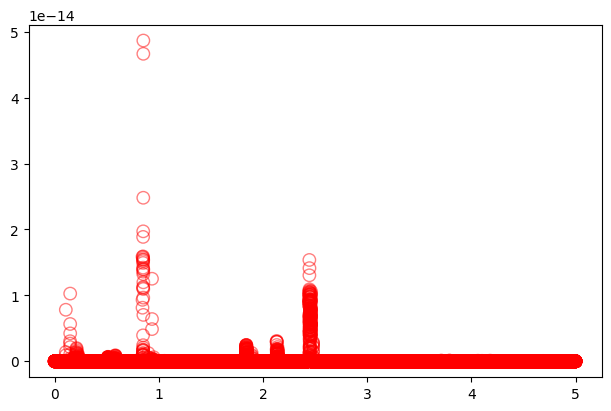

In [9]:
plt.scatter(np.linspace(0,5,len(mean_signal)), 
            (mean_signal < mean_background)*(mean_background - mean_signal),
            s=80,facecolors='none', edgecolors='r', alpha=0.5)

# Testing stuff

In [10]:
def bartlett_psd(x, fs, nperseg):    
    nsegments = len(x) // nperseg
    psd = np.zeros(nperseg)
    for segment in x.reshape(nsegments, nperseg):
        psd += np.abs(np.fft.fft(segment))**2 / nperseg
    psd[0] = 0   # important!!
    psd /= nsegments
    psd = psd[0 : nperseg//2]
    freq = np.linspace(0, fs/2, nperseg//2)
    return freq, psd

50001


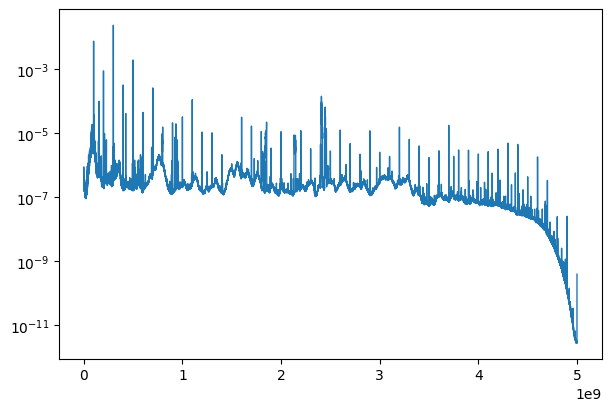

In [11]:
freqs_welch, psd_welch = scipy.signal.welch(data_signal[0],
                   fs=10e9,
                   nperseg=100_000,
                   noverlap=0,  # zero for Barlett's method.
                   return_onesided=True,
                   scaling='density',
                   axis=-1,
                   average='mean',
                  )

for data in data_signal[1:]:
    _, new_psd = scipy.signal.welch(data,
                   fs=10e9,
                   nperseg=100_000,
                   noverlap=0,  # zero for Barlett's method.
                   return_onesided=True,
                   scaling='density',
                   axis=-1,
                   average='mean',
                  )
    psd_welch += new_psd
    
psd_welch /= len(data_signal)

print(np.size(psd_welch))
plt.semilogy(freqs_welch, psd_welch * 10e9 / 2 )

50000


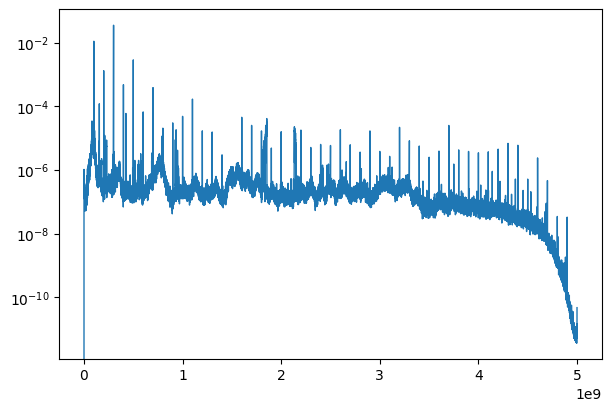

In [12]:
freqs_barlett, psd_barlett = bartlett_psd(data_signal[0][:-2], 
                   fs=10e9, 
                   nperseg=100_000,
                  )

print(np.size(psd_barlett))
plt.semilogy(freqs_barlett, psd_barlett)

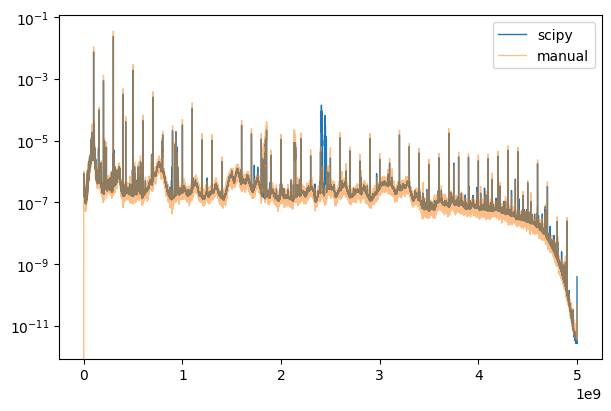

In [13]:
plt.semilogy(freqs_welch, psd_welch * 10e9 / 2, label='scipy')
plt.semilogy(freqs_barlett, psd_barlett, alpha=.5, label='manual')
plt.legend()